# Zero Pressure Gradient Flat Plate

![plate](http://turbmodels.larc.nasa.gov/FlatPlate/Grids/plateBCpic.jpg)
    
#### References
    
http://turbmodels.larc.nasa.gov/flatplate.html

## Define case name
This is the solver case to be analysed

In [1]:
from collections import OrderedDict
case_dict = OrderedDict((   ('plate_medium',{ 'label' : '(68x48 cells)','face_area':0.075823,}),
                            ('plate_medium_f20',{'label' : '(68x48 cells)','face_area':0.075823,}),
                            ('plate_medium_f50',{'label' : '(68x48 cells)','face_area':0.075823,}),
                            ('plate_medium_f100',{'label' : '(68x48 cells)','face_area':0.075823,}),
                            ('plate_medium_f300',{'label' : '(68x48 cells)','face_area':0.075823,}),
                            ('plate_fine',{'label' : '(544x384 cells)','face_area':0.075823/8.0,})
                        ))

## Define Data Location
For remote data the interaction will use ssh to securely interact with the data<br/>
This uses the reverse connection capability in paraview so that the paraview server can be submitted to a job scheduler<br/>
Note: The default paraview server connection will use port 11111

In [2]:
remote_data = True
remote_server_auto = True

data_host='dstandingford@vis03'
data_dir='/gpfs/thirdparty/zenotech/home/dstandingford/VALIDATION/PLATE'
paraview_cmd='mpiexec /gpfs/cfms/apps/zCFD/bin/pvserver'
job_queue='westmere'
job_ntasks=4
job_ntaskpernode=2
job_project='hyperflux'

if not remote_server_auto:
    paraview_cmd=None

if not remote_data:
    data_host='localhost'
    paraview_cmd=None

# from zutil.post import data_location_form_html
# data_location_form_html()


## zCFD Validation

In [3]:
# Validation criteria is the value of the friction coefficient [0.0024 < c_f < 0.0028]  at x = 0.97
validate = True
if (validate):
    valid = True
    valid_lower = 0.0024
    valid_upper = 0.0028
    print 'VALIDATING PLATE CASE'

VALIDATING PLATE CASE


### Initialise Environment

In [4]:
%pylab inline
from paraview.simple import *
paraview.simple._DisableFirstRenderCameraReset()
import pylab as pl
import math
import numpy as np

Populating the interactive namespace from numpy and matplotlib
paraview version 4.2.0-77-g31a1d2a


### Data Connection
This starts paraview server on remote host and connects

In [5]:
from zutil.post import pvserver_connect
if remote_data:
    pvserver_connect(data_host=data_host,data_dir=data_dir,paraview_cmd=paraview_cmd)

Testing passwordless ssh access
-> Passed
Attempting to find unused port
[dstandingford@vis03] Executing task 'run_uname'
[dstandingford@vis03] Executing task 'port_test'
[dstandingford@vis03] Executing task 'port_test'
Selected Port: 12002
Starting pvserver connect
[dstandingford@vis03] Executing task 'port_test'
Starting pvserver process
[dstandingford@vis03] Executing task 'pvserver'
[dstandingford@vis03] run: /bin/bash -l -c "cd /gpfs/thirdparty/zenotech/home/dstandingford/VALIDATION/PLATE && sleep 2;mpiexec /gpfs/cfms/apps/zCFD/bin/pvserver -rc --client-host=localhost -sp=12002"
[dstandingford@vis03] out: 
[dstandingford@vis03] out: 		   _____ ______ __  __  _____ 
[dstandingford@vis03] out: 		  / ____|  ____|  \/  |/ ____|
[dstandingford@vis03] out: 		 | |    | |__  | \  / | (___  
[dstandingford@vis03] out: 		 | |    |  __| | |\/| |\___ \ 
[dstandingford@vis03] out: 		 | |____| |    | |  | |____) |
[dstandingford@vis03] out: 		  \_____|_|    |_|  |_|_____/ 
[dstandingford@vis03]

Get control dictionary

In [6]:
from zutil.post import get_case_parameters,print_html_parameters
parameters={}
for case_name in case_dict:
    print 'case name = ' + case_name
    parameters[case_name] = get_case_parameters(case_name,data_host=data_host,data_dir=data_dir)

case name = plate_medium
case name = plate_medium_f20
case name = plate_medium_f50
case name = plate_medium_f100
case name = plate_medium_f300
case name = plate_fine


Get status file

In [7]:
from zutil.post import get_status_dict
status=get_status_dict(case_name,data_host=data_host,data_dir=data_dir)
num_procs = str(status['num processor'])

### Define test conditions

In [8]:
from IPython.display import HTML
for case_name in case_dict:
    HTML(print_html_parameters(parameters[case_name]))

In [9]:
# Analysis constants
import zutil
reference_area = 2.0
bl_position = 0.97
mach = parameters['plate_fine']['IC_1']['V']['Mach']
print 'mach = %.2f'%(mach)
kappa = 1.402
print 'kappa = %.3f'%(kappa)
R = 287.058
print 'R = %.3f'%(R)
temperature = zutil.to_kelvin(540.0)
print 'temperature = %.2f'%(temperature) + ' Kelvin'
pressure = parameters['plate_fine']['IC_1']['pressure']
print 'pressure = %.2f'%(pressure) + ' Pascals'

density = pressure/(R*temperature)
print 'density = %.2f'%(density) + ' kg/m^3'
speed_of_sound = sqrt(kappa*pressure/density)
print 'speed_of_sound = %.2f'%(speed_of_sound) + ' m/s'
u_ref = mach*speed_of_sound 
print 'u_ref = %.2f'%(u_ref) + ' m/s'

mach = 0.20
kappa = 1.402
R = 287.058
temperature = 300.00 Kelvin
pressure = 101325.00 Pascals
density = 1.18 kg/m^3
speed_of_sound = 347.47 m/s
u_ref = 69.49 m/s


### Plotting functions

In [10]:
from zutil.post import get_case_root, get_case_report
from zutil.post import get_csv_data,get_fw_csv_data
from zutil.post import for_each
def plot_theory(ax, filename):
    df = get_fw_csv_data(filename,widths=[16,16,16,16,16])
    ax.plot(df[1], df[0], color='grey', label='$\mathbf{u^{+}=y^{+}}$')    
    ax.plot(df[2], df[0], color='grey', label='Log law')    

def plot_comparison(ax,filename):
    df = get_fw_csv_data(filename,widths=[16,14],skiprows=2)    
    ax.plot(df[0], df[1], color='red', label='CFL3D (545x385 points)')    
 
def velocity_plot(data,pts,**kwargs):
    ax = kwargs['axis']
    chart_label = kwargs['chart_label']
    ax.plot(data.GetPointData()['vprof'], pts.GetPoints()[:,2], label=chart_label)    

def plot_velocity_profile(ax,file_root,label,face_area):
    wall = PVDReader( FileName=file_root+'_wall.pvd' )
    drag = MinMax(Input=wall)
    drag.Operation = "SUM"
    drag.UpdatePipeline()
    drag_client = servermanager.Fetch(drag)
    cd = drag_client.GetCellData().GetArray("frictionforce").GetValue(0)
    wall_slice = Slice(Input=wall, SliceType="Plane" )
    wall_slice.SliceType.Normal = [1.0,0.0,0.0]
    wall_slice.SliceType.Origin = [bl_position, 0.0, 0.0]
    wall_slice.UpdatePipeline()
    wall_slice_client = servermanager.Fetch(wall_slice)
    nu = wall_slice_client.GetCellData().GetArray("nu").GetValue(0)
    utau = wall_slice_client.GetCellData().GetArray("ut").GetValue(0)
    yplus = wall_slice_client.GetCellData().GetArray("yplus").GetValue(0)
    cf    = wall_slice_client.GetCellData().GetArray("frictionforce").GetValue(0)
    wall_vel = wall_slice_client.GetCellData().GetArray("V").GetValue(0)
    wall_vel = 0.0
    symmetry = PVDReader( FileName=file_root+'_symmetry.pvd' )
    CellDatatoPointData1 = CellDatatoPointData(Input=symmetry)
    CellDatatoPointData1.PassCellData = 1
    # Removes second symmetry plane keeping y max
    Clip1 = Clip(Input=CellDatatoPointData1, ClipType="Plane" )
    Clip1.ClipType.Normal = [0.0,1.0,0.0]
    Clip1.ClipType.Origin = [0.0, -0.5, 0.0]
    Clip2 = Clip(Input=Clip1, ClipType="Plane" )
    Clip2.ClipType.Normal = [0.0,0.0,1.0]
    Clip2.ClipType.Origin = [0.0, 0.0, 0.05]
    Clip2.InsideOut = 1
    Slice1 = Slice(Input=Clip2, SliceType="Plane" )
    Slice1.SliceType.Normal = [1.0,0.0,0.0]
    Slice1.SliceType.Origin = [bl_position, 0.0, 0.0]
    Calculator2 = Calculator(Input=Slice1)
    Calculator2.AttributeMode = 'Point Data'
    Calculator2.Function = '(V.iHat - '+ str(wall_vel) +')'
    Calculator2.ResultArrayName = 'vprof'
    Calculator2.UpdatePipeline()
    sorted_line = PlotOnSortedLines(Input=Calculator2)
    sorted_line.UpdatePipeline()
    extract_client = servermanager.Fetch(sorted_line) 
    chart_label = (('$\mathbf{y^{+} = %.2f}$')%(yplus) + (' $\mathbf{C_d=%.6f}$'%(cd/reference_area)) 
                      + (' $\mathbf{C_f=%.5f}$'%(cf/face_area)) + ' ' + label)
    for_each(extract_client,velocity_plot,axis=ax,chart_label=chart_label)
    
def bl_plot(data,pts,**kwargs):
    ax = kwargs['axis']
    chart_label = kwargs['chart_label']
    ax.plot(data.GetPointData()['yp'][1:], data.GetPointData()['up'][1:], label=chart_label)    

def get_case_cf(file_root,label,face_area):
    wall = PVDReader( FileName=file_root+'_wall.pvd' )
    wall_slice = Slice(Input=wall, SliceType="Plane" )
    wall_slice.SliceType.Normal = [1.0,0.0,0.0]
    wall_slice.SliceType.Origin = [bl_position, 0.0, 0.0]
    wall_slice.UpdatePipeline()
    wall_slice_client = servermanager.Fetch(wall_slice)
    cf = wall_slice_client.GetCellData().GetArray("frictionforce").GetValue(0)/face_area
    return(cf) 
    
def plot_profile(ax,file_root,label):
    wall = PVDReader( FileName=file_root+'_wall.pvd' )
    wall_slice = Slice(Input=wall, SliceType="Plane" )
    wall_slice.SliceType.Normal = [1.0,0.0,0.0]
    wall_slice.SliceType.Origin = [bl_position, 0.0, 0.0]
    wall_slice.UpdatePipeline()
    wall_slice_client = servermanager.Fetch(wall_slice)
    nu = wall_slice_client.GetCellData().GetArray("nu").GetValue(0)
    utau = wall_slice_client.GetCellData().GetArray("ut").GetValue(0)
    yplus = wall_slice_client.GetCellData().GetArray("yplus").GetValue(0)
    t = wall_slice_client.GetCellData().GetArray("T").GetValue(0)
    p = wall_slice_client.GetCellData().GetArray("p").GetValue(0)
    rho = wall_slice_client.GetCellData().GetArray("rho").GetValue(0)
    wall_vel = wall_slice_client.GetCellData().GetArray("V").GetValue(0)
    symmetry = PVDReader( FileName=file_root+'_symmetry.pvd' )
    CellDatatoPointData1 = CellDatatoPointData(Input=symmetry)
    CellDatatoPointData1.PassCellData = 1
    # Removes second symmetry plane keeping y max
    Clip1 = Clip(Input=CellDatatoPointData1, ClipType="Plane" )
    Clip1.ClipType.Normal = [0.0,1.0,0.0]
    Clip1.ClipType.Origin = [0.0, -0.5, 0.0]
    Clip2 = Clip(Input=Clip1, ClipType="Plane" )
    Clip2.ClipType.Normal = [0.0,0.0,1.0]
    Clip2.ClipType.Origin = [0.0, 0.0, 0.05]
    Clip2.InsideOut = 1
    Slice1 = Slice(Input=Clip2, SliceType="Plane" )
    Slice1.SliceType.Normal = [1.0,0.0,0.0]
    Slice1.SliceType.Origin = [bl_position, 0.0, 0.0]
    Calculator1 = Calculator(Input=Slice1)
    Calculator1.AttributeMode = 'Point Data'
    Calculator1.Function = 'log10(coords.kHat * '+str(utau)+'/'+str(nu)+')'
    Calculator1.ResultArrayName = 'yp'
    Calculator2 = Calculator(Input=Calculator1)
    Calculator2.AttributeMode = 'Point Data'
    Calculator2.Function = '(V.iHat - '+ str(wall_vel) +')/ '+str(utau)
    Calculator2.ResultArrayName = 'up'
    Calculator2.UpdatePipeline()
    sorted_line = PlotOnSortedLines(Input=Calculator2)
    sorted_line.UpdatePipeline()
    extract_client = servermanager.Fetch(sorted_line) 
    chart_label = (('$\mathbf{y^{+} = %.2f}$')%(yplus) + ' ' 
                    + ('$\mathbf{u_{T} = %.2f}$')%(utau) + ' ' + label)
    for_each(extract_client,bl_plot,axis=ax,chart_label=chart_label)
    

## Plot comparison with Law of the Wall

/Applications/paraview.app/Contents/Python/paraview/vtk/numpy_interface/dataset_adapter.py:126: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if array == None:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

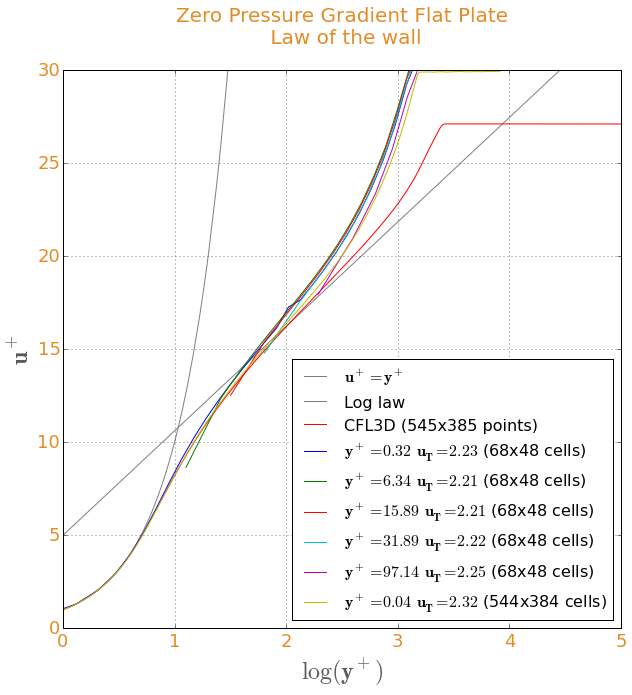

/Users/David/Documents/zPost/ipynb/FLATPLATE/images/flat_plate_bl_profile_a.png

In [11]:
from zutil.post import ProgressBar
pbar = ProgressBar()
fig = figure(figsize=(10, 10),dpi=150, facecolor='w', edgecolor='#E48B25')

ax = fig.add_subplot(1,1,1)
ax.grid(True)
ax.set_xlabel('$\mathbf{\log(y^{+})}$', fontsize=24, fontweight='bold', color = '#5D5858')
ax.set_ylabel('$\mathbf{u^{+}}$', fontsize=24, fontweight='bold', color = '#5D5858')
ax.set_title('Zero Pressure Gradient Flat Plate \n Law of the wall \n', fontsize=20, fontweight='normal', color = '#E48B25')
ax.axis([0,5,0,30])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
    tick.label.set_fontweight('normal') 
    tick.label.set_color('#E48B25')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    tick.label.set_fontweight('normal') 
    tick.label.set_color('#E48B25')
    
plot_theory(ax,'data/u+y+theory.csv');
plot_comparison(ax,'data/flatplate_u+y+_sst.dat');

for case in case_dict:
    case_name = case
    label = case_dict[case]['label']
    plot_profile(ax,get_case_root(case_name,str(num_procs)),label)
    pbar+=5
    
legend = ax.legend(loc='best', shadow=False, fontsize=16)
legend.get_frame().set_facecolor('white')

pbar.complete()
show()
fig.savefig("images/flat_plate_bl_profile_a.png", transparent="True")
from IPython.display import FileLink, display 
display(FileLink('images/flat_plate_bl_profile_a.png')) 

## Plot Velocity Profile

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

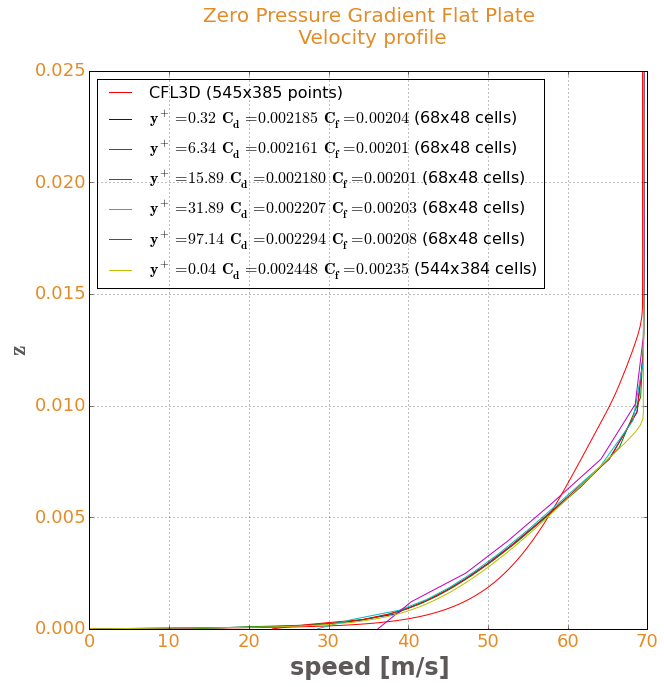

/Users/David/Documents/zPost/ipynb/FLATPLATE/images/flat_plate_bl_profile_b.png

In [12]:
pbar = ProgressBar()
fig = figure(figsize=(10, 10), dpi=150, facecolor='w', edgecolor='#E48B25')
ax = fig.add_subplot(1,1,1)
ax.grid(True)
ax.set_xlabel('speed [m/s]', fontsize=24, fontweight='bold', color = '#5D5858')
ax.set_ylabel('$\mathbf{z}$', fontsize=24, fontweight='bold', color = '#5D5858')
ax.set_title('Zero Pressure Gradient Flat Plate \n Velocity profile \n', fontsize=20, 
             fontweight='normal', color = '#E48B25')
ax.set_xlim([0.0,70.0])
ax.set_ylim([0.0,0.025])

df = get_fw_csv_data('data/flatplate_u_sst.dat',widths=[16,14],skiprows=2)    
ax.plot(df[0]*u_ref, df[1], color='red', label='CFL3D (545x385 points)')    

pbar+=5
for case in case_dict:
    case_name = case
    label = case_dict[case]['label']
    plot_velocity_profile(ax,get_case_root(case_name,str(num_procs)),label,case_dict[case]['face_area'])
    pbar+=5
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
    tick.label.set_fontweight('normal') 
    tick.label.set_color('#E48B25')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    tick.label.set_fontweight('normal') 
    tick.label.set_color('#E48B25')    
    
ax.legend(loc='best', shadow=False, fontsize=16)
legend.get_frame().set_facecolor('white')
pbar+=5
pbar.complete()
fig.savefig("images/flat_plate_bl_profile_b.png", transparent="True")
show()
display(FileLink('images/flat_plate_bl_profile_b.png')) 


## Mesh Convergence

<IPython.core.display.Javascript object>

INVALID: plate_medium 0.0024 0.00204489981245 0.0028


<IPython.core.display.Javascript object>

INVALID: plate_medium_f20 0.0024 0.00200660879365 0.0028


<IPython.core.display.Javascript object>

INVALID: plate_medium_f50 0.0024 0.00201421494883 0.0028


<IPython.core.display.Javascript object>

INVALID: plate_medium_f100 0.0024 0.00202568175746 0.0028


<IPython.core.display.Javascript object>

INVALID: plate_medium_f300 0.0024 0.00208497952136 0.0028


<IPython.core.display.Javascript object>

INVALID: plate_fine 0.0024 0.0023515945292 0.0028


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

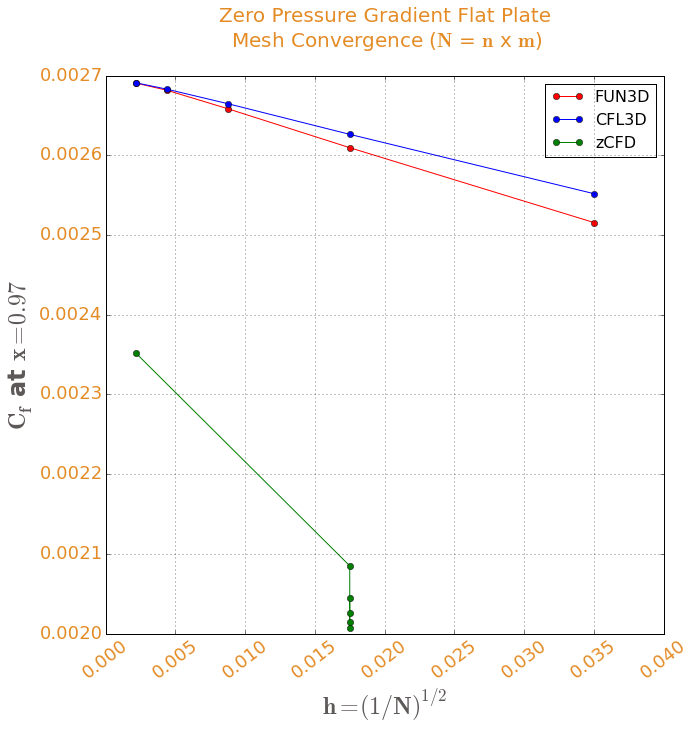

/Users/David/Documents/zPost/ipynb/FLATPLATE/images/flat_plate_mesh_conv_profile.png

In [13]:
pbar = ProgressBar()
fig = figure(figsize=(10, 10),dpi=150, facecolor='w', edgecolor='#E48B25')
ax = fig.add_subplot(1,1,1)

ax.grid(True)
ax.set_xlabel('$\mathbf{h=(1/N)^{1/2}}$', fontsize=24, fontweight='bold', color = '#5D5858')
ax.set_ylabel('$\mathbf{C_f}$ at $\mathbf{x=0.97}$', fontsize=24, fontweight='bold', color = '#5D5858')
ax.set_title('Zero Pressure Gradient Flat Plate \n Mesh Convergence ($\mathbf{N}$ = $\mathbf{n}$ x $\mathbf{m}$) \n', fontsize=20, 
             fontweight='normal', color = '#E48B25')

df = get_fw_csv_data('data/cf_convergence_sst_fun3d.dat',widths=[8,13,12,21],skiprows=3) 
ax.plot(df[2], df[3], color='red', marker='o',label='FUN3D')    
df = get_fw_csv_data('data/cf_convergence_sst_cfl3d.dat',widths=[8,13,12,21],skiprows=3) 
ax.plot(df[2], df[3], color='blue', marker='o',label='CFL3D')
pbar+=5

h = []
cf = []
for case in case_dict:
    case_name = case
    label = case_dict[case]['label']
    if (label=='(68x48 cells)'):
        N = 68*48
    elif (label=='(544x384 cells)'):
        N = 544*384
    h.append(1.0/sqrt(N))
    cf_temp = get_case_cf(get_case_root(case_name,str(num_procs)),label,case_dict[case]['face_area']) 
    cf.append(cf_temp)
    if (validate):
        if ((cf_temp < valid_lower) or (cf_temp > valid_upper)):
            valid = False
            print 'INVALID: ' + case + ' ' + str(valid_lower) + ' ' + str(cf_temp) + ' ' + str(valid_upper)
    pbar+=5

ax.plot(h, cf, color='green', marker='o',label='zCFD') 
pbar+=5

ax.legend(loc='best', shadow=False, fontsize=16)
legend.get_frame().set_facecolor('white')
pbar+=5

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
    tick.label.set_fontweight('normal') 
    tick.label.set_color('#E48B25')
    tick.label.set_rotation(37.5)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    tick.label.set_fontweight('normal')
    tick.label.set_color('#E48B25')  

fig.savefig("images/flat_plate_mesh_conv_profile.png")
pbar.complete()
show()
from IPython.display import FileLink, display 
display(FileLink('images/flat_plate_mesh_conv_profile.png')) 

## Convergence

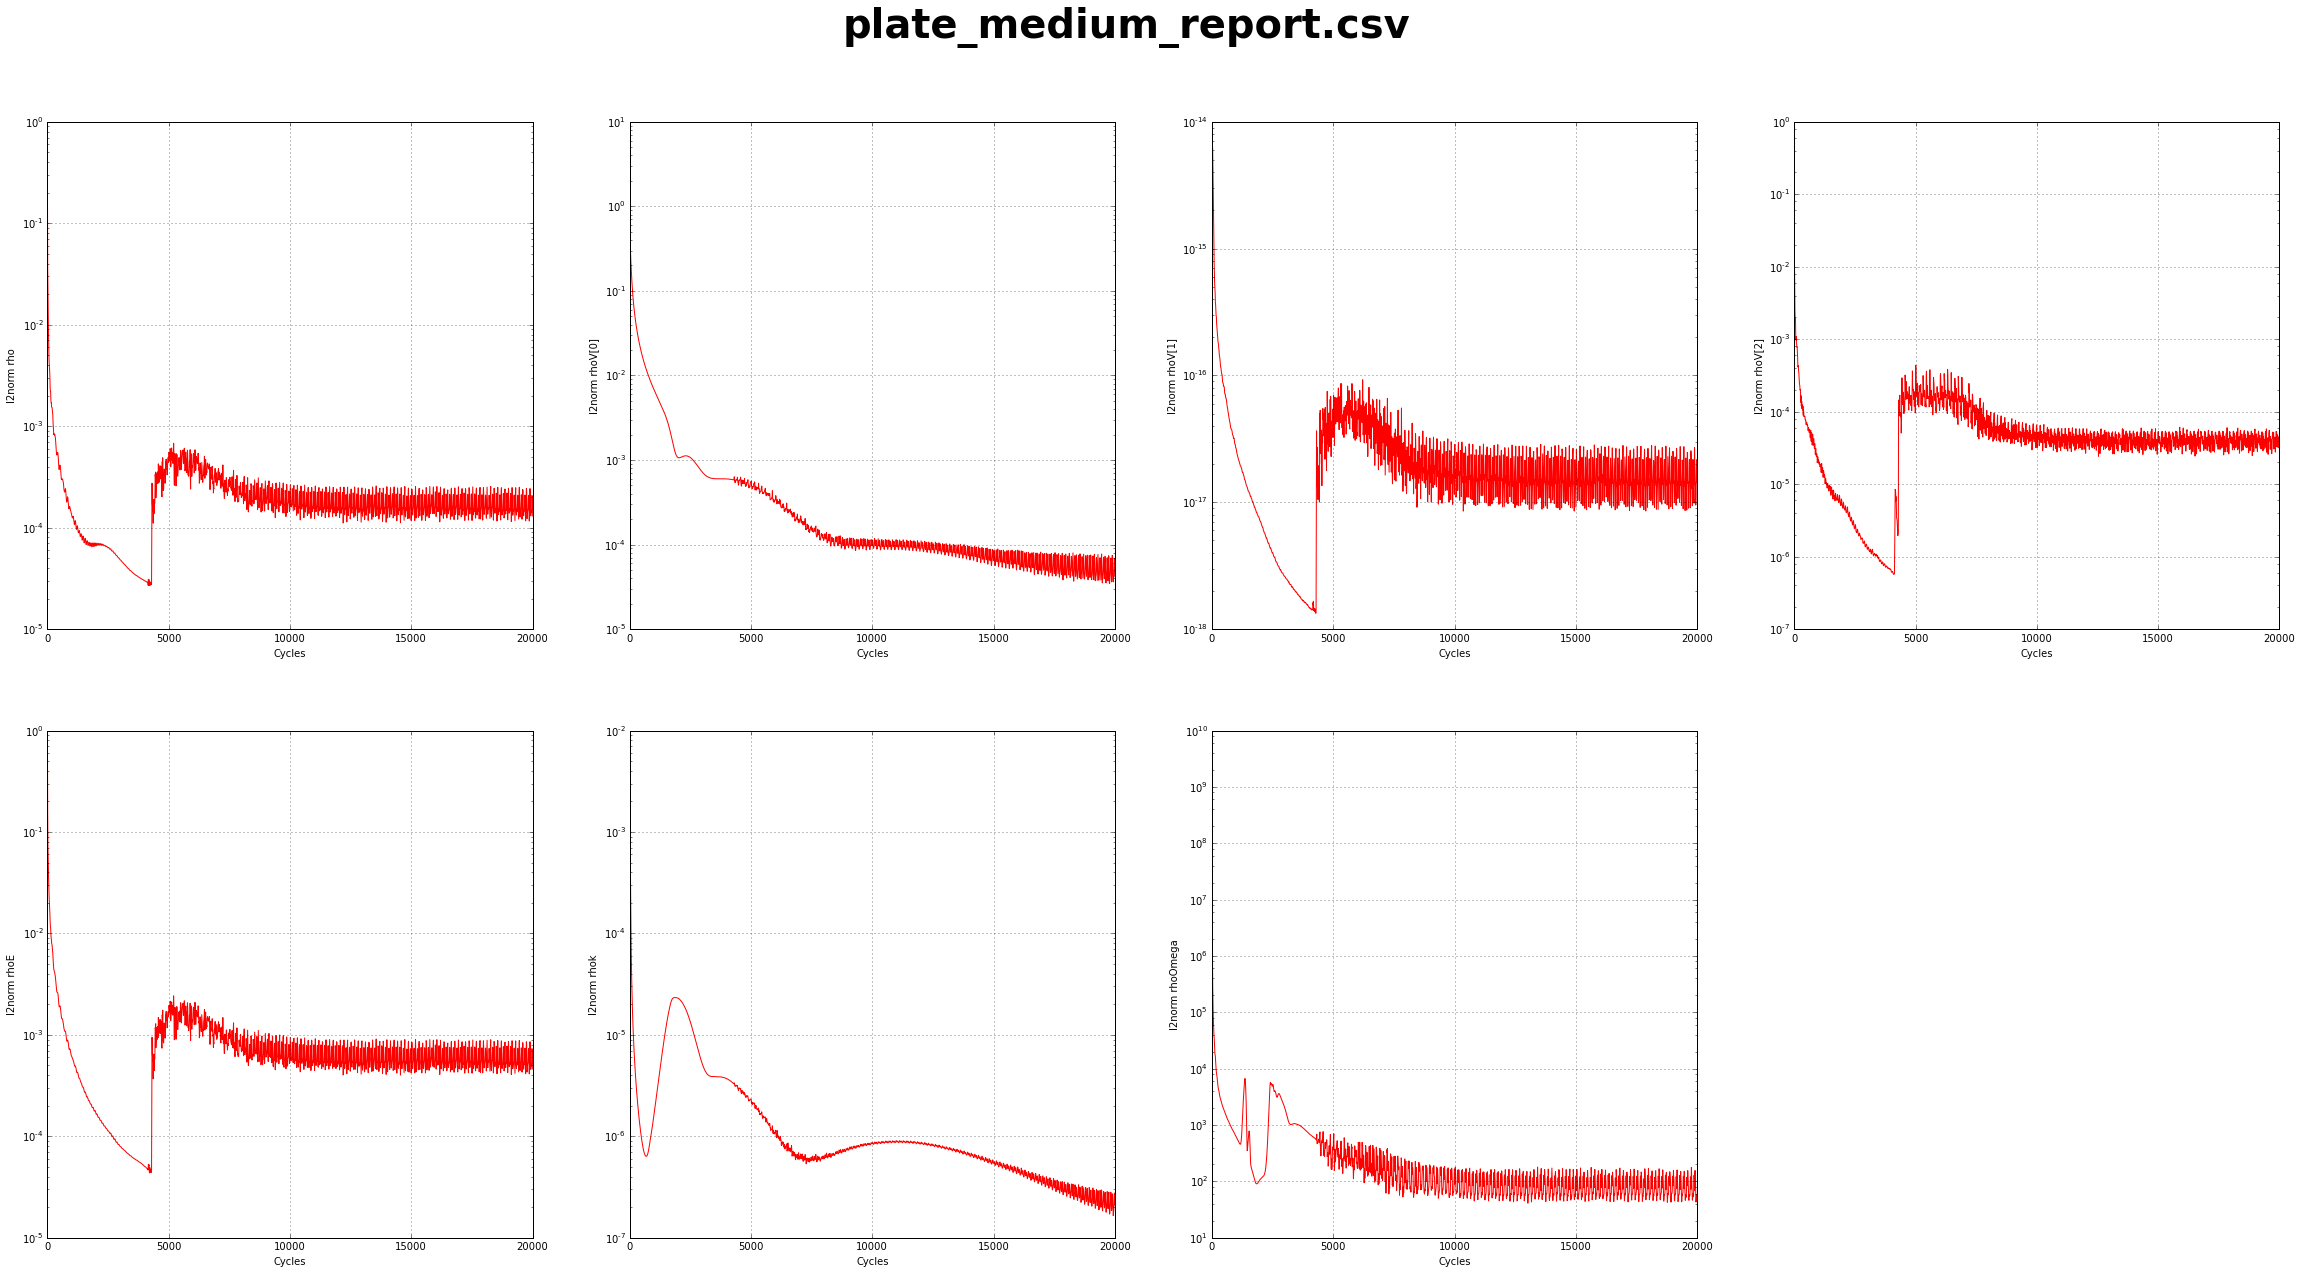

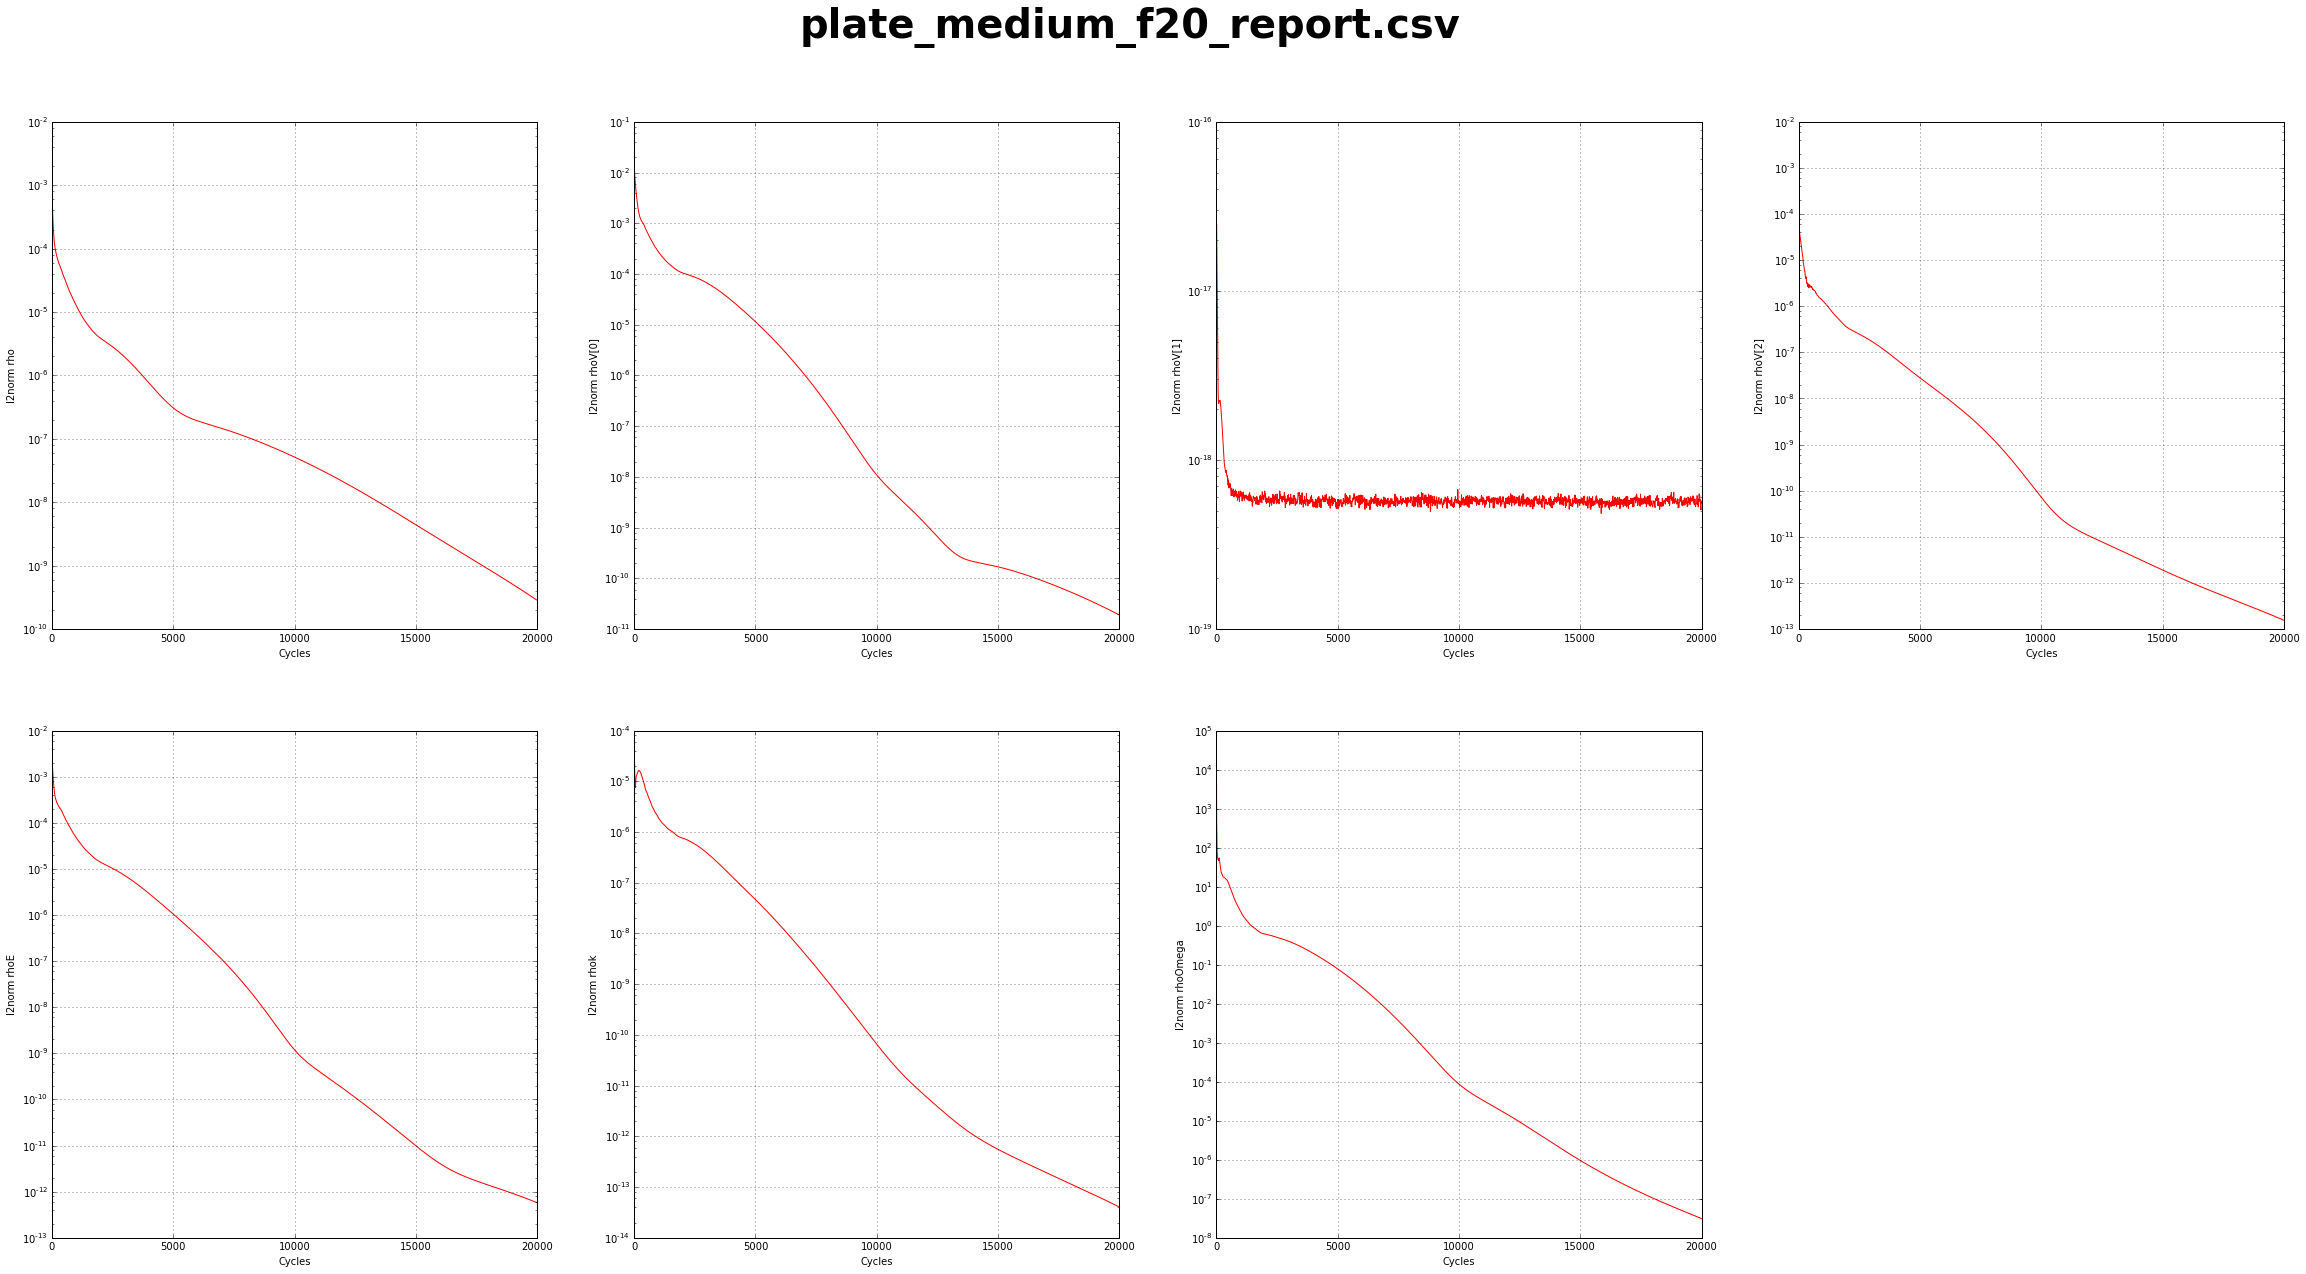

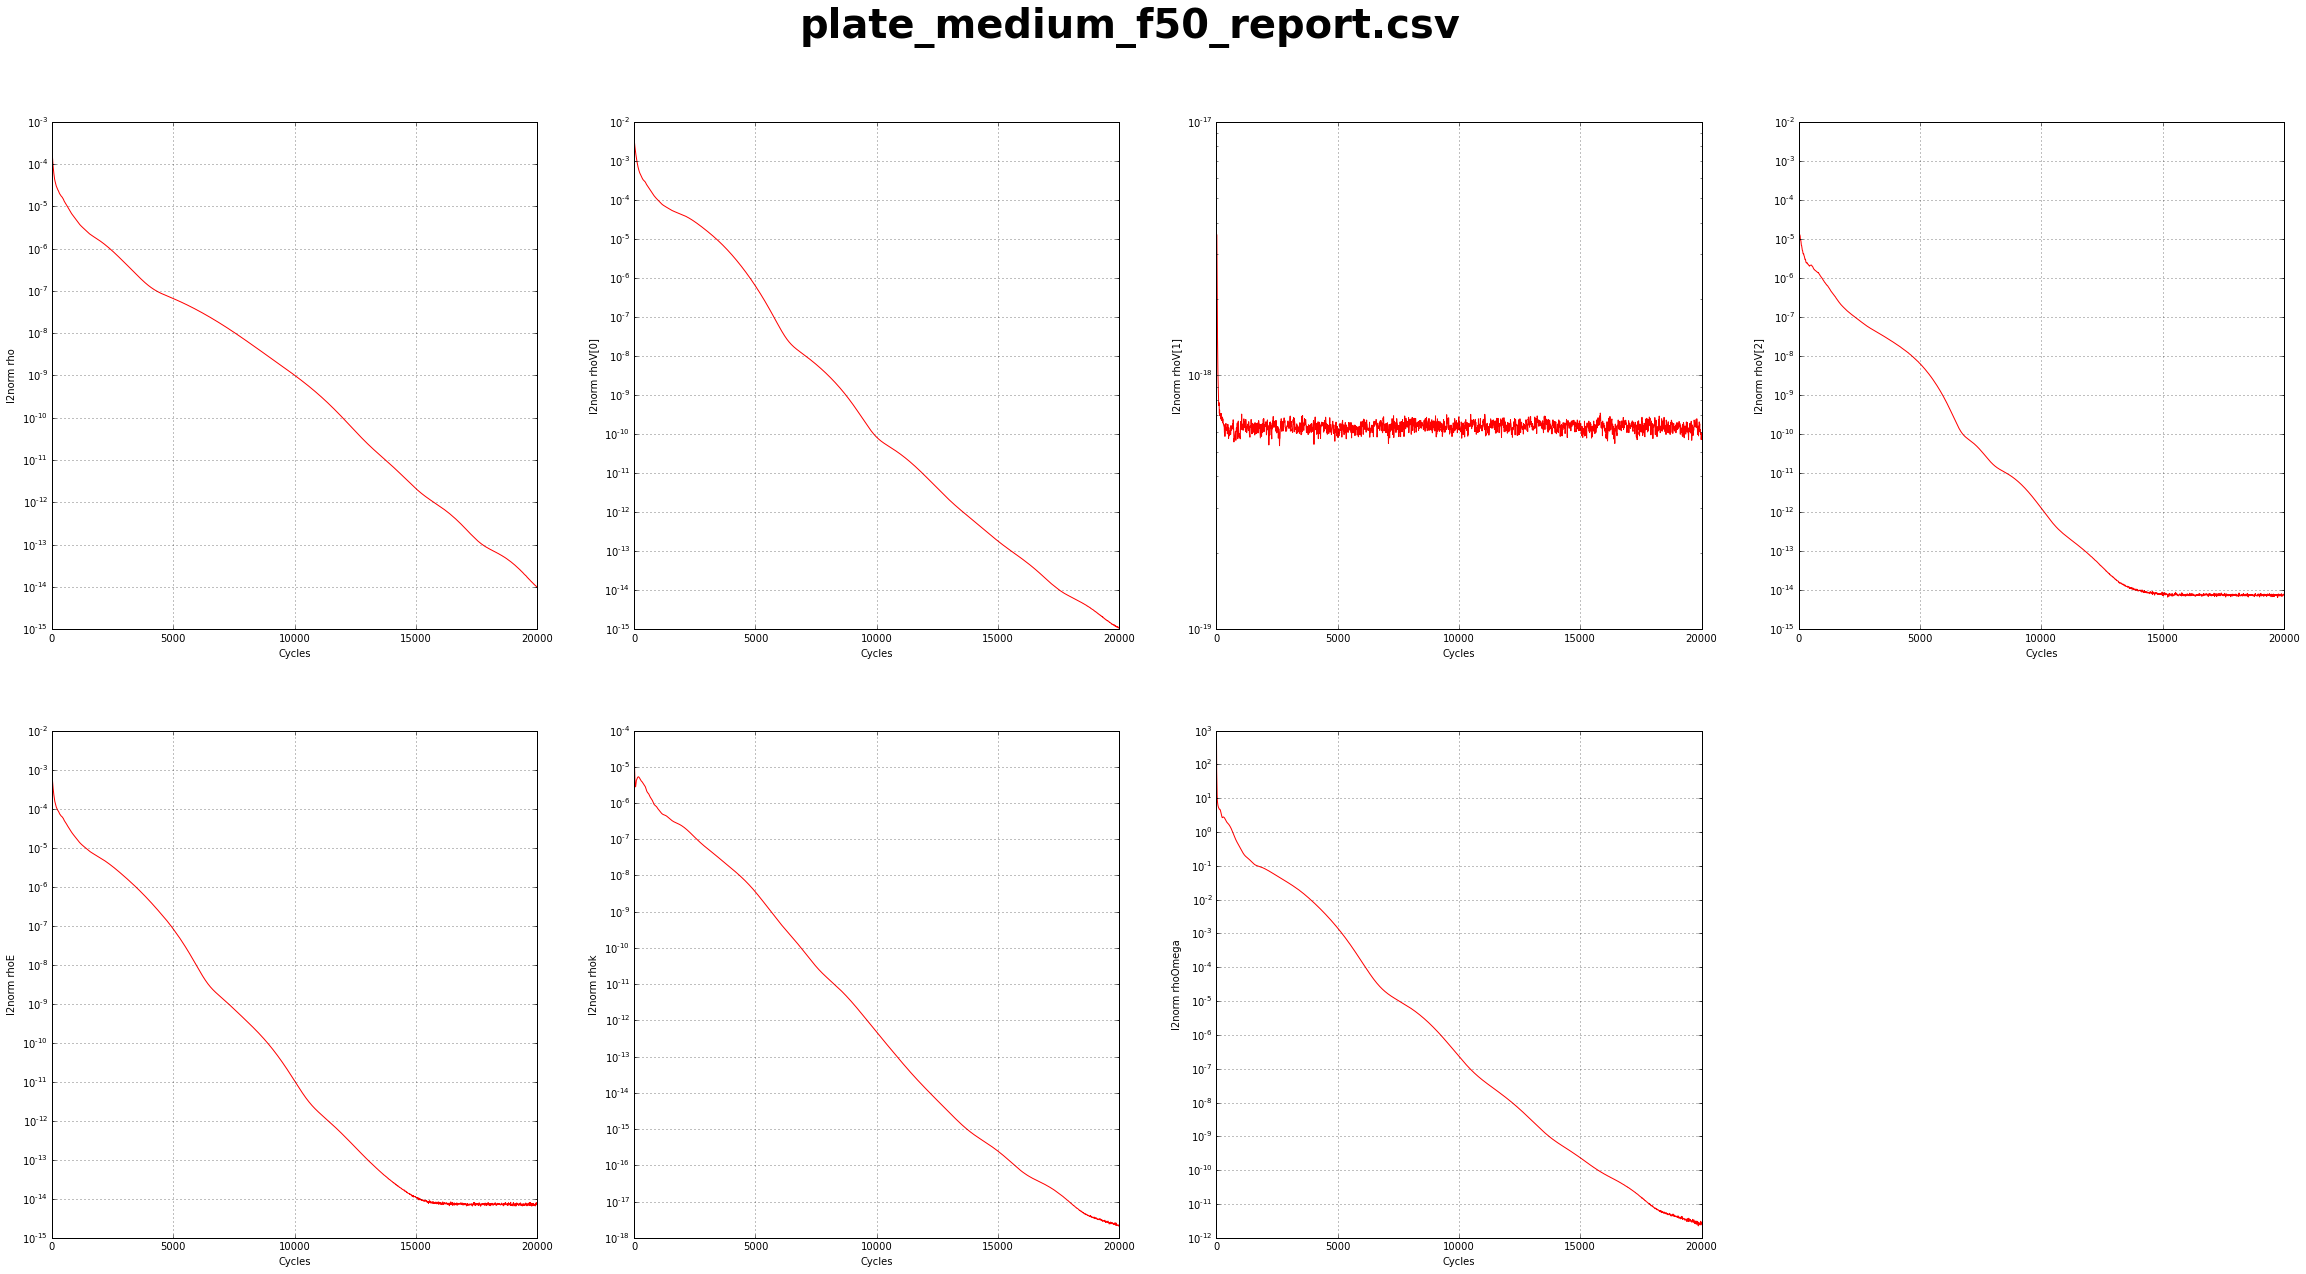

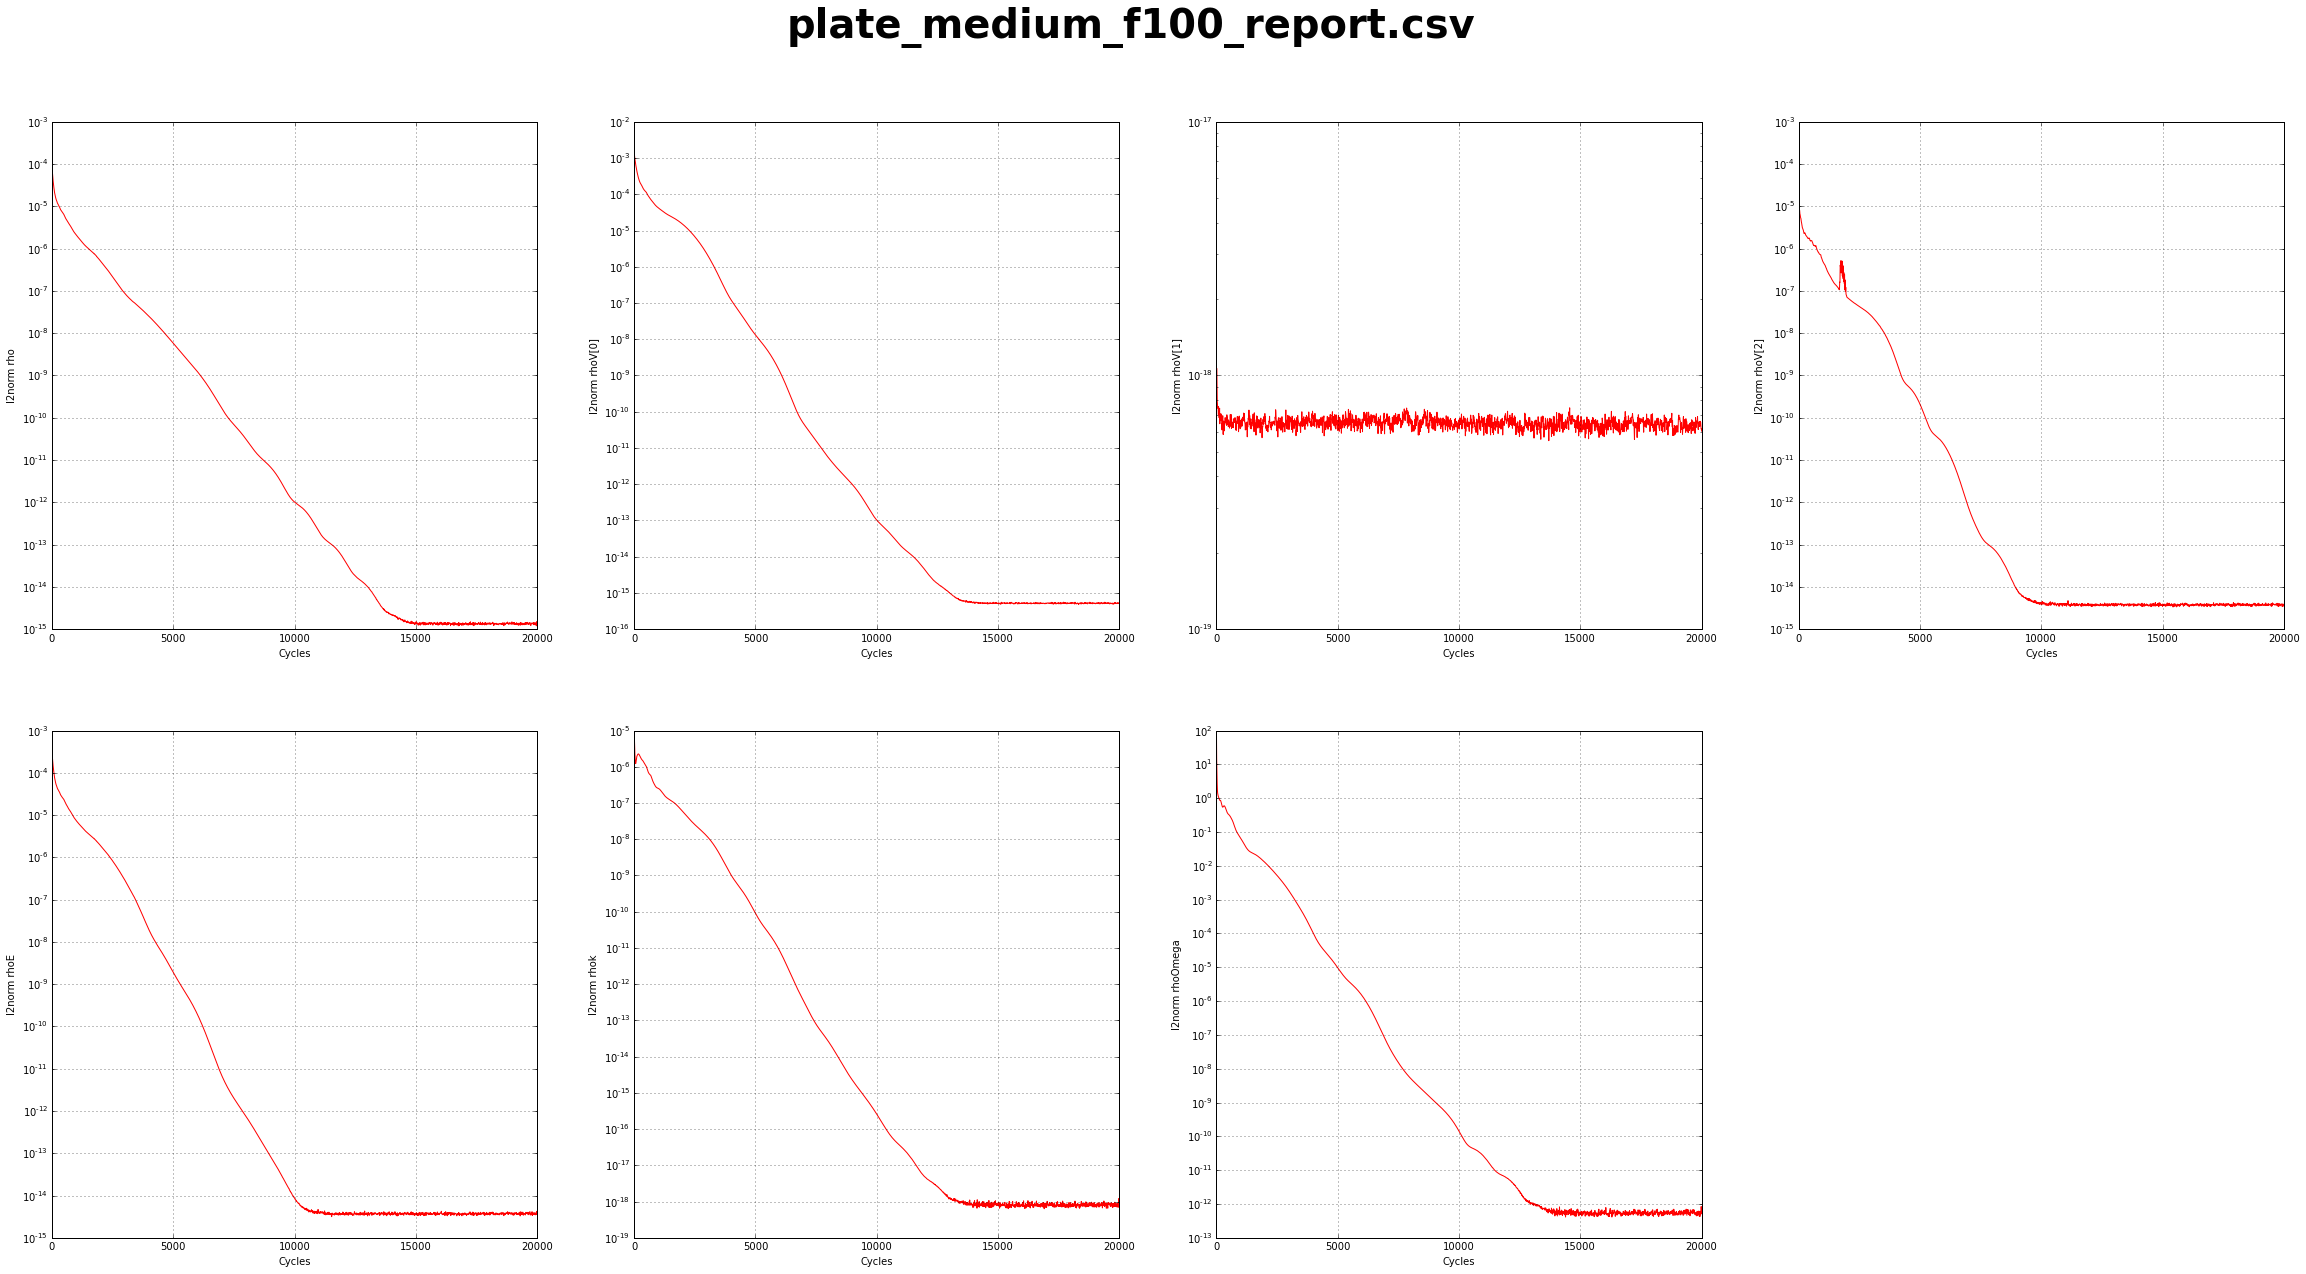

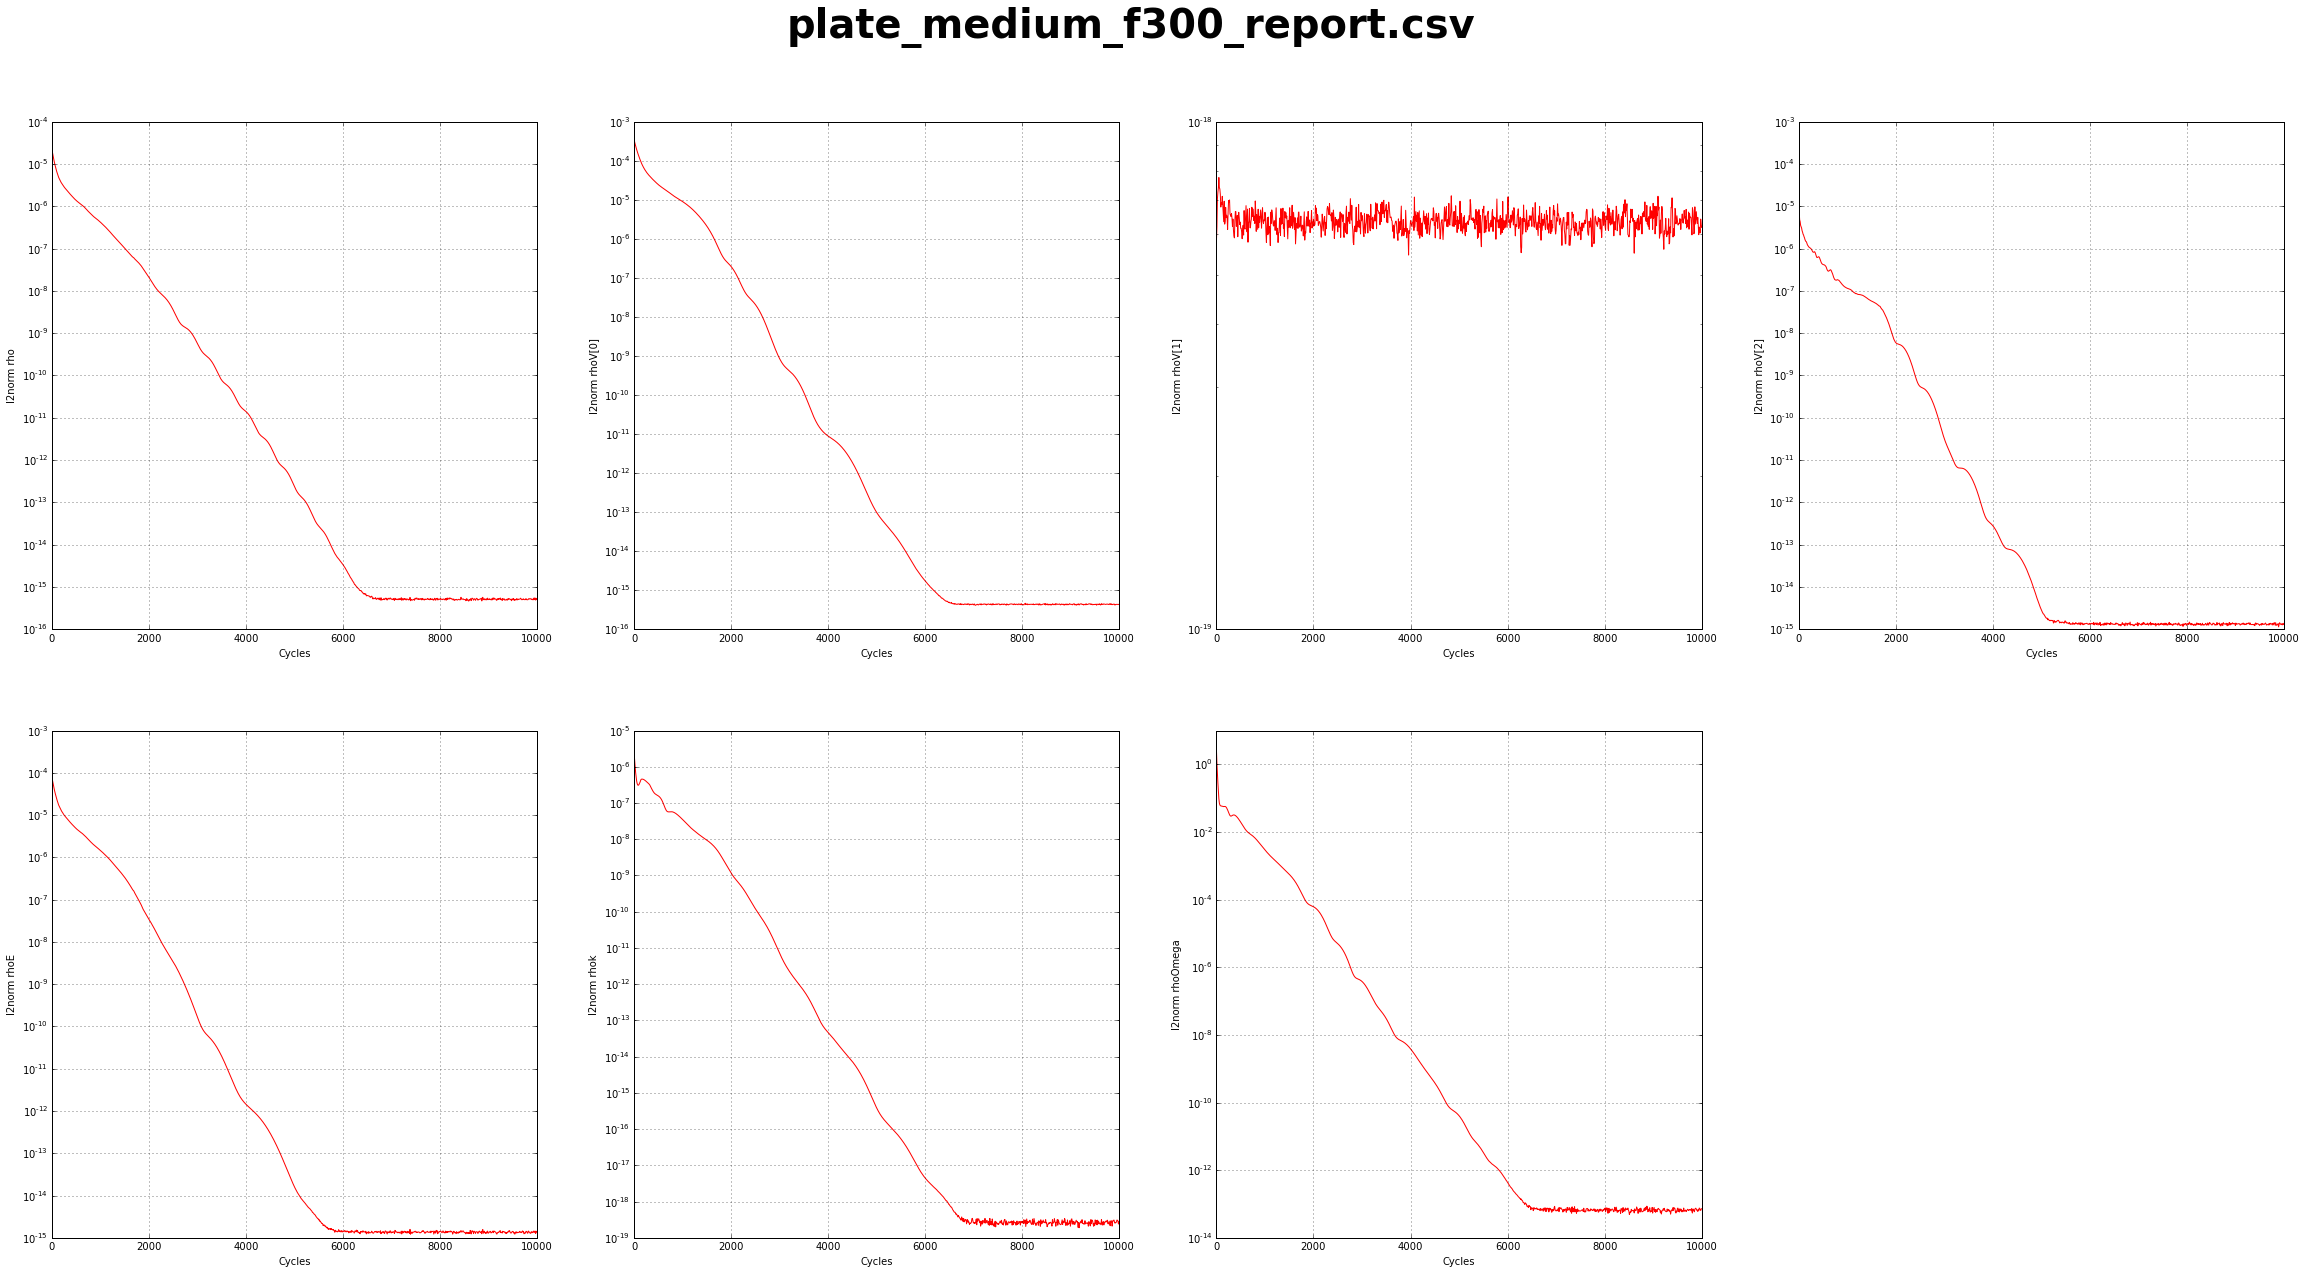

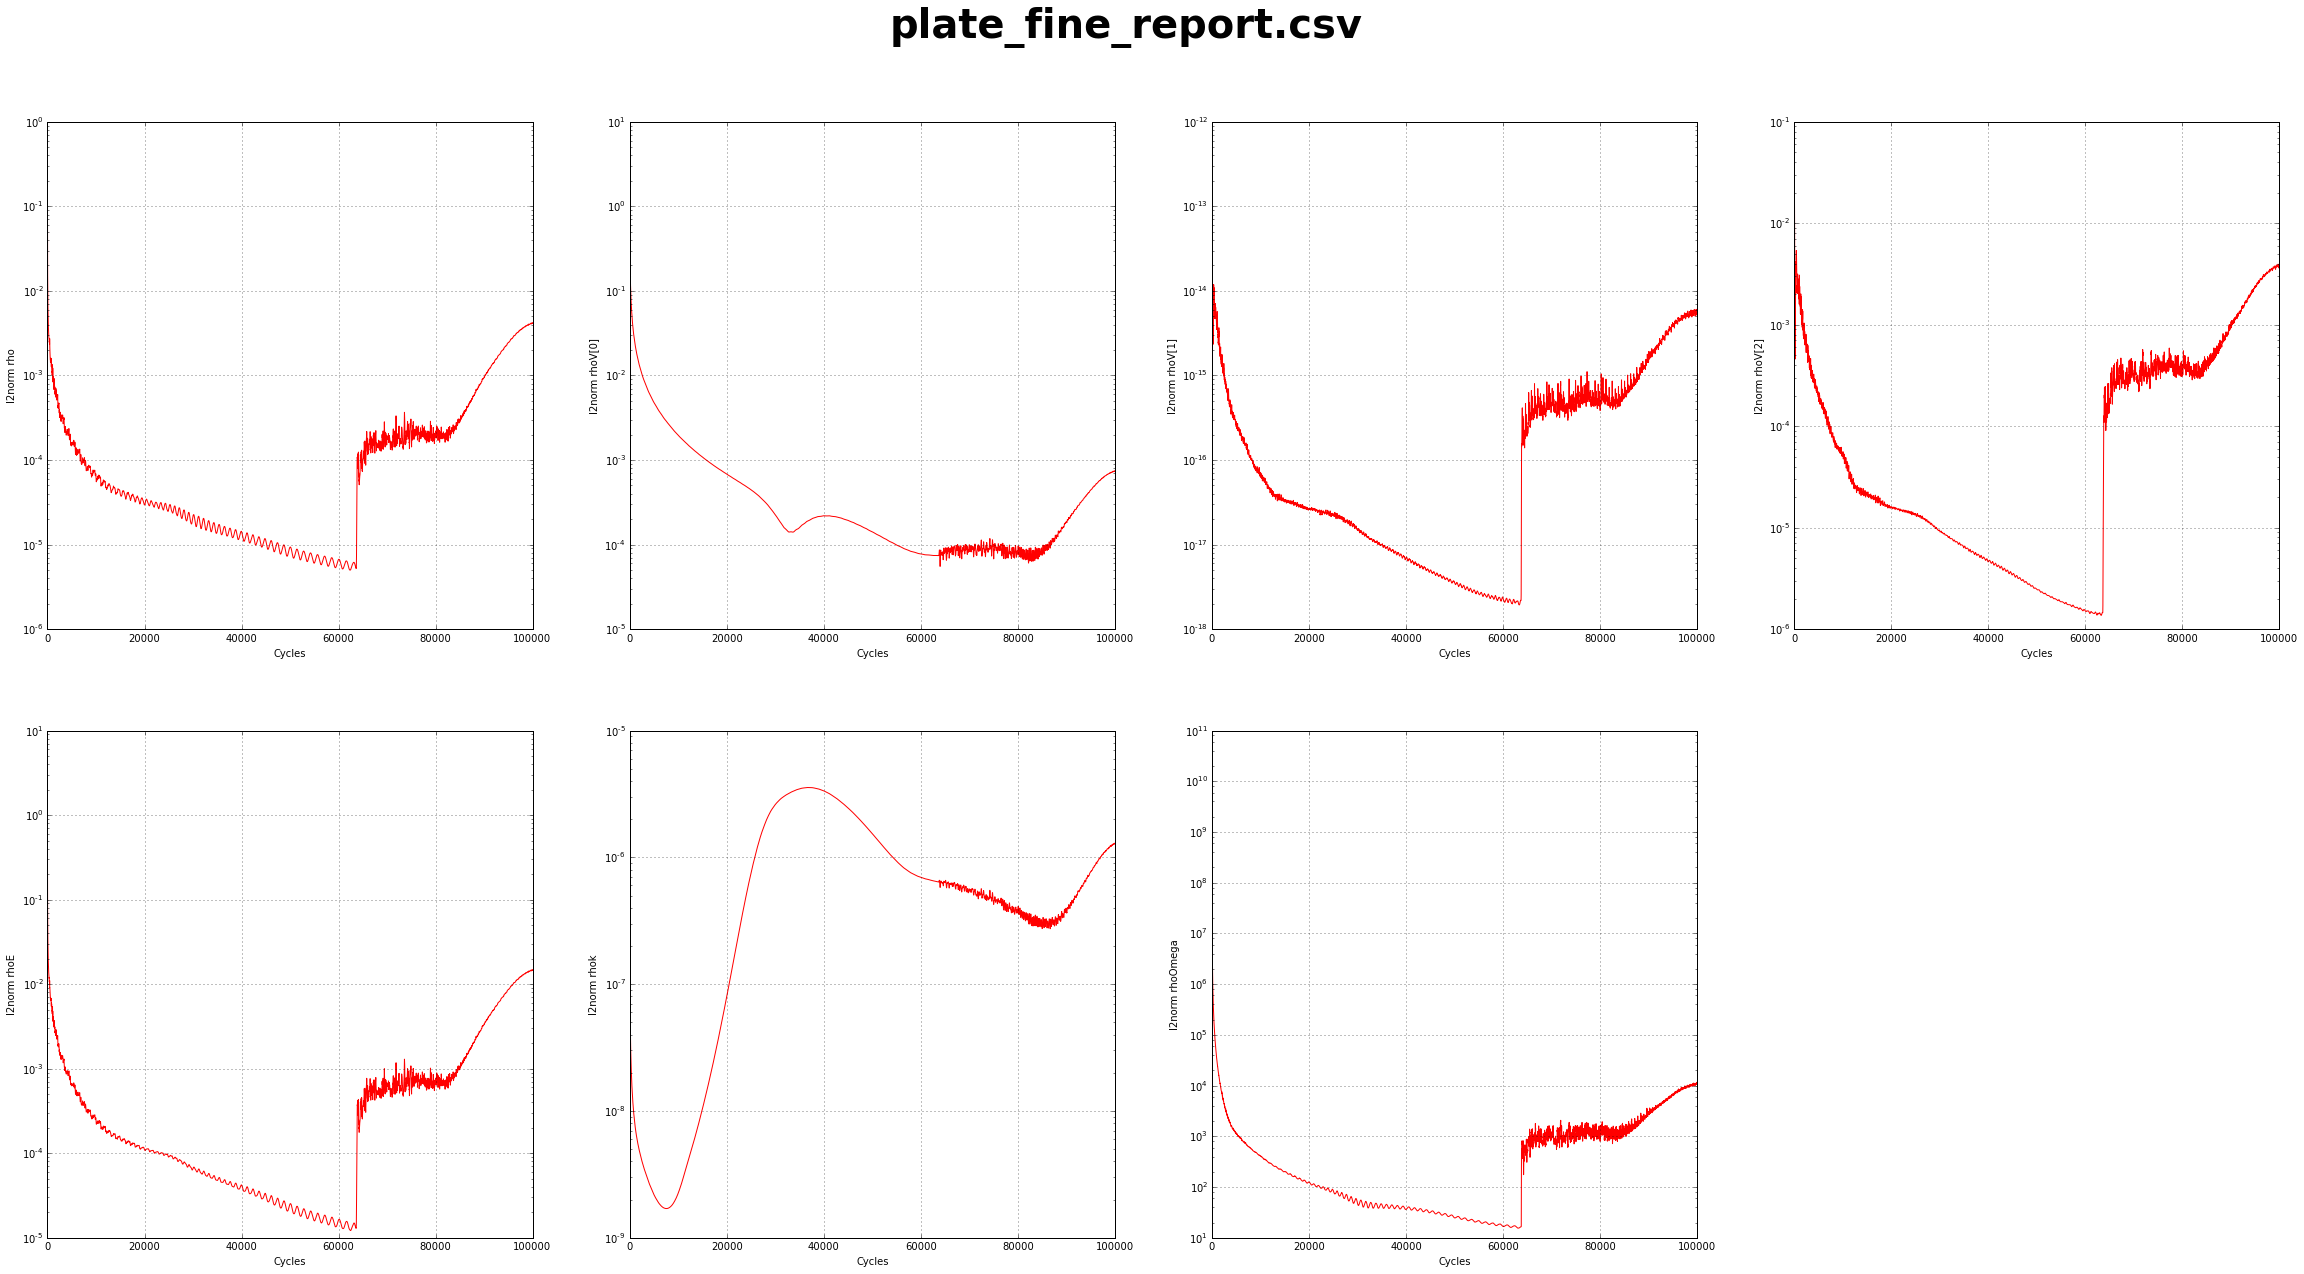

In [14]:
from zutil.post import residual_plot, get_case_report
for case_name in case_dict:
    residual_plot(get_case_report(case_name))
show()

### Check Validation 

In [15]:
if (validate):
    if (valid):
        print 'VALIDATION = PASS :-)'
    else:
        print 'VALIDATION = FAIL :-('    

VALIDATION = FAIL :-(


### Cleaning up

In [16]:
if remote_data:
    print 'Disconnecting from remote paraview server connection'
    Disconnect()
    pass

Disconnecting from remote paraview server connection
Exiting...
[dstandingford@vis03] out: 

<script type="text/javascript">
     show=true;
     function toggle(){
        if (show){
             $('div.input').hide();
         }else{
             $('div.input').show();
         }
         show = !show
     }
</script>
<a href="javascript:toggle()" target="_self">toggle input</a>